In [1]:
%load_ext autoreload
%autoreload 2

import tqdm
import warnings
import numpy as np
import pylab as plt
from numpy import pi
from time import time
from imcn.utility import timer
from jitcsim import plot_order
from multiprocessing import Pool
from numpy.random import uniform
from imcn import calc_TE, calc_MI
from jitcsim.models.kuramoto_sde import Kuramoto_II
from imcn import time_average_correlation_matrix
warnings.filterwarnings("ignore") 

In [2]:
def run_for_each(coupl, parameters, num_threads=1):
    """
    run the simulation for each coupling
    The initial state and frequencies are changed.

    Parameters
    -----------
    coupl : float
        coupling strength 
    
    parameters : dict
        parameters for the simulation
    num_threads : int
        number of threads for infodynamics calculation

    return: dict("g"=coupl, "R"=R, "te"=te, "cor"=cor)
        - g : coupling strength
        - R : time average order parameter
        - te: time average transfer entropy
        - mi: time average mutual information
        - cor: selected elements of time average correlation matrix
    """

    N = parameters["N"]
    controls = [coupl]
    I = Kuramoto_II(parameters)
    I.set_initial_state(uniform(-pi, pi, N))
    I.set_integrator_parameters(atol=1e-5, rtol=1e-3)
    data = I.simulate(controls, mode_2pi=False)
    x = data['x']

    # selected links
    links = [(0, 1), (0, 2), (1, 2)]
    corr = time_average_correlation_matrix(x, step=10)
    cor = np.zeros(len(links))
    
    for i in range(len(links)):
        e = links[i]
        cor[i] = corr[e[0], e[1]]

    te = np.zeros(len(links))
    mi = np.zeros(len(links))

    for i in range(len(links)):
        source_id = links[i][0]
        target_id = links[i][1]
        source = x[:-1, source_id]
        target = np.diff(x[:, target_id])
        if parameters["CALCUALTE_TE"]:
            te[i] = calc_TE(source,
                            target,
                            num_threads=num_threads)
        if parameters["CALCULATE_MI"]:
            mi[i] = calc_MI(source,
                            target,
                            TIME_DIFF=0,
                            NUM_THREADS=num_threads
                            )

    # time average order parameter
    R = np.mean(I.order_parameter(x))

    return {"g": coupl,
            "R": R,
            "te": te,
            "mi": mi,
            "cor": cor}
@timer
def batch_run(parameters, couplings, num_ensembles, num_links, num_workers=1):
    """
    run simulations in parallel using multiprocessing

    Parameters
    -------------

    parameters : dict
        parameters for the simulation
    couplings : list, array of float
        list of couplings
    num_ensembles: int
        number of ensembles for simulations
    num_links: int
        number of links for calculation of TE and Correlations

    return: dict("R"=R, "TE"=TE, "Cor"=Cor)
        R: array of time average order parameters for each coupling strength
        TE: 2d array of TE for each link and for each coupling strength [num_couplings by num_links]
        Cor: 2d array of correlations for each link and for each coupling strength [num_couplings by num_links]

    """

    par = []
    for i in range(len(couplings)):
        for j in range(num_ensembles):
            par.append(couplings[i])
    
    num_simulations = len(par)

    def update_bar(_):
            pbar.update()

    with Pool(processes=num_workers) as pool:
        with tqdm.tqdm(total=num_simulations) as pbar:
            async_results = [pool.apply_async(run_for_each, args=(par[i], parameters, 1),
                                                callback=update_bar)
                                for i in range(num_simulations)]
            data = [async_result.get() for async_result in async_results]

    R = [d['R'] for d in data]
    TE = [d['te'] for d in data]
    MI = [d['mi'] for d in data]
    Cor = [d["cor"] for d in data]

    results = {}
    R = np.reshape(R, (len(couplings), num_ensembles))
    R = np.mean(R, axis=1) # average over ensembles
    results["R"] = R

    Cor = np.reshape(Cor, (len(couplings), num_ensembles, num_links))
    Cor = np.mean(Cor, axis=1)  
    results["Cor"] = Cor

    if parameters["CALCUALTE_TE"]:
        TE = np.reshape(TE, (len(couplings), num_ensembles, num_links))
        TE = np.mean(TE, axis=1) 
        results["TE"] = TE

    if parameters["CALCULATE_MI"]:
        MI = np.reshape(MI, (len(couplings), num_ensembles, num_links))
        MI = np.mean(MI, axis=1)
        results["MI"] = MI

    return results


In [3]:
np.random.seed(2)

# SETTING PARAMETERS --------------------------------------------
N = 3
omega = [0.3, 0.4, 0.5]
initial_state = uniform(-pi, pi, N)
noise_amplitude = 0.005

# aij means there is a link from j to i
adj = np.asarray([
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 0]
])

parameters = {
    'N': N,                             # number of nodes
    'adj': adj,                         # adjacency matrix
    't_initial': 0.,                    # initial time of integration
    "t_final": 500,                     # final time of integration
    't_transition': 400.0,              # transition time
    "interval": 0.05,                   # time interval for sampling

    "alpha": 0.0,                       # frustration
    "sigma": noise_amplitude,           # noise amplitude
    "omega": omega,                     # initial angular frequencies
    'initial_state': initial_state,     # initial phase of oscillators
    'control': ["coupling"],            # control parameters

    "use_omp": False,                   # use OpenMP
    "output": "data",                   # output directory
    "CALCUALTE_TE": True,
    "CALCULATE_MI": True
}

couplings = np.linspace(0.01, 0.3, 41)
num_ensembles = 5
num_processes = 8
num_threads = 1


In [4]:
# compilings ----------------------------------------------------
sol = Kuramoto_II(parameters)
sol.compile()

compiled C code


In [5]:
# running the simulation in parallel ----------------------------
data = batch_run(parameters, couplings, num_ensembles, num_links=3, num_workers=num_processes)


100%|██████████| 205/205 [00:33<00:00,  6.14it/s]

batch_run Done in 0 hours 0 minutes 33.5540 seconds


In [6]:
# saving to file ------------------------------------------------
np.savez("data/toy_sde_data",
            g=couplings,
            R=data['R'],
            Cor=data['Cor'],
            TE=data['TE'],
            MI=data['MI']
            )

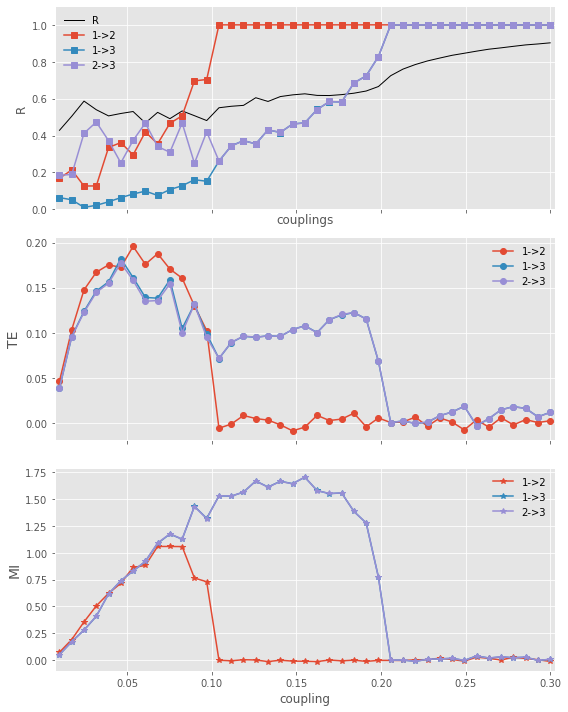

In [7]:
# ploting -------------------------------------------------------
plt.style.use("ggplot")
fig, ax = plt.subplots(3, figsize=(8, 10), sharex=True)
plot_order(couplings,
            data['R'],
            ax=ax[0],
            xlabel="couplings",
            ylabel="R",
            label="R",
            figsize=(8, 5),
            close_fig=False)

labels = ["1->2", "1->3", "2->3"]
Cor = data["Cor"]
TE = data["TE"]
MI = data["MI"]

for i in range(3):
    ax[0].plot(couplings, Cor[:, i], marker="s", label=labels[i])

for i in range(3):
    ax[1].plot(couplings, TE[:, i], marker="o", label=labels[i])

for i in range(3):
    ax[2].plot(couplings, MI[:, i], marker="*", label=labels[i])

for i in range(3):
    ax[i].legend(frameon=False)
ax[-1].set_xlabel("coupling")
ax[1].set_ylabel("TE", fontsize=14)
ax[2].set_ylabel("MI", fontsize=14)

plt.tight_layout()
plt.savefig("data/toy_sde_fig.png", dpi=150)
# plt.close()